In [51]:
# Goal : Create Model for Prediction of heart disease using feature engineering

# Steps followed
# 1) Introduce the data
# 2) Exploration
# 3) Data cleaning
# 4) Feature engineering
# 5) Model training
# 
# How it is done
#         i)   using pandas and sklearn for modeling
#         ii)  Feature engineering
#                   a) Using statistical measures
#                   b) Using Random Projections
#                   c) Using clustering
#                   d) USing interaction variables
#        iii)  Feature selection
#                   a) Using derived feature importance from modeling
#                   b) Using sklearn FeatureSelection Classes
#         iv)  One hot encoding of categorical variables
#          v)  Classifciation using Decision Tree and RandomForest

In [52]:
# 1.0 Clear memory
%reset -f

# 1.1 Call data manipulation libraries
import pandas as pd
import numpy as np

# 1.2 Feature creation libraries
from sklearn.random_projection import SparseRandomProjection as sr  # Projection features
from sklearn.cluster import KMeans                    # Cluster features
from sklearn.preprocessing import PolynomialFeatures  # Interaction features

# 1.3 For feature selection
# Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Selection criteria

# 1.4 Data processing
# 1.4.1 Scaling data in various manner
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
# 1.4.2 Transform categorical (integer) to dummy
from sklearn.preprocessing import OneHotEncoder

# 1.5 Splitting data
from sklearn.model_selection import train_test_split

# 1.6 Decision tree modeling
from sklearn.tree import  DecisionTreeClassifier as dt

# 1.7 RandomForest modeling
from sklearn.ensemble import RandomForestClassifier as rf

# 1.8 Plotting libraries to plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# 1.9 Misc
import os, time, gc

In [53]:
# 2.0 Set working directory and read file
print(os.listdir("../input"))


['heart.csv']


In [54]:
# 2.1 Read heart.csv file
heart_data = pd.read_csv("../input/heart.csv")

In [55]:
#2.2 understand the heart data
heart_data.shape     
heart_data.head(2)
heart_data.dtypes.value_counts()

int64      13
float64     1
dtype: int64

In [56]:
#  303 observation and 14 features
#  Only Continous numeric data and no categorical
#  13 heart related features and 1 target column


In [57]:
# Let us drop the target column from the dataframe before working on features

target = heart_data['target']
target.tail(2)

heart_data.drop(columns = ['target'], inplace = True)
heart_data.shape  

heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [58]:
# 3 Check if there are Missing values?
heart_data.isnull().sum().sum() 

0

In [59]:
# 4 Let us see graphs for age and Cholestrol before we proceed
age = heart_data.loc[ : , 'age']
chol = heart_data.loc[ :, 'chol']

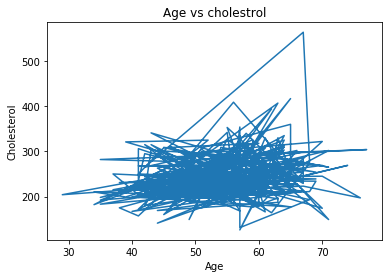

In [60]:
plt.figure()
plt.title('Age vs cholestrol')
plt.xlabel ('Age')
plt.ylabel ('Cholesterol')
plt.plot(age,chol)
plt.show()

In [61]:
# 5 add more derived features using sum, count, var, median, mean, std, max, min
heart_data['sum'] = heart_data.sum(numeric_only = True, axis=1)


feat = [ "var", "median", "mean", "std", "max", "min"]
for i in feat:
    heart_data[i] = heart_data.aggregate(i,  axis =1)

In [62]:
heart_data.shape

(303, 20)

In [63]:
# store column names of the data
colNames = heart_data.columns.values
colNames

array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sum', 'var',
       'median', 'mean', 'std', 'max', 'min'], dtype=object)

In [64]:
# 6 Transform to array before applying random projection
tmp = heart_data.values

# create 4 random projection column
NUM_OF_COM = 4

# Create an instance of class
rp_instance = sr(n_components = NUM_OF_COM)

#  fit and transform the (original) dataset
#  Random Projections with desired number of components are returned
rp = rp_instance.fit_transform(tmp[:, :13])

In [65]:
# Look at some features
rp[: 5, :  3]  

array([[  -0.94941446,   -0.94941446, -364.57515305],
       [  -0.94941446,   -2.84824338, -415.84353394],
       [   0.        ,   -1.89882892, -356.97983736],
       [  -0.94941446,   -2.84824338, -394.00700134],
       [   0.94941446,   -2.84824338, -490.84727637]])

In [66]:
# create some column names
rp_col_names = ["r" + str(i) for i in range(5)]
rp_col_names

['r0', 'r1', 'r2', 'r3', 'r4']

In [67]:
# 7 Before clustering, scale data for unit variance
# Create a StandardScaler instance
se = StandardScaler()
# fit and transform() in one step
tmp = se.fit_transform(tmp)
tmp.shape

(303, 20)

In [68]:
# No of centroids is no of classes in the 'target'
centers = target.nunique()    # 2 unique classes
centers             

2

In [69]:
# 8 Begin clustering

# First create object to perform clustering
kmeans = KMeans(n_clusters=centers, # How many
                n_jobs = 2)         # Parallel jobs for n_init


# Next train the model on the original data only
kmeans.fit(tmp[:, : 13])

kmeans.labels_
kmeans.labels_.size

303

In [70]:
# Create an instance of OneHotEncoder class
ohe = OneHotEncoder(sparse = False)

# Use ohe to learn data
#  ohe.fit(kmeans.labels_)
ohe.fit(kmeans.labels_.reshape(-1,1))     

# Transform data now
dummy_clusterlabels = ohe.transform(kmeans.labels_.reshape(-1,1))
dummy_clusterlabels
dummy_clusterlabels.shape 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(303, 2)

In [71]:
# create some more column names
k_means_names = ["k" + str(i) for i in range(2)]
k_means_names

['k0', 'k1']

In [72]:
# Generate polynomial and interaction features

degree = 2
poly = PolynomialFeatures(degree,                 # Degree 2
                          interaction_only=True,  # Avoid e.g. square(a)
                          include_bias = False    # No constant term
                          )

df =  poly.fit_transform(tmp[:, : 5])

df.shape


(303, 15)

In [73]:
# Create polynomial columns
poly_names = [ "poly" + str(i)  for i in range(15)]
poly_names

['poly0',
 'poly1',
 'poly2',
 'poly3',
 'poly4',
 'poly5',
 'poly6',
 'poly7',
 'poly8',
 'poly9',
 'poly10',
 'poly11',
 'poly12',
 'poly13',
 'poly14']

In [74]:
# check the shape of the data 
tmp.shape

(303, 20)

In [75]:
if ('dummy_clusterlabels' in vars()):               #
    tmp = np.hstack([tmp,rp,dummy_clusterlabels, df])
else:
    tmp = np.hstack([tmp,rp, df]) 

In [76]:
tmp.shape

(303, 41)

In [77]:
X = tmp[: heart_data.shape[0], : ]
X.shape

(303, 41)

In [78]:
# No longer need tmp as entering next stage to split the data for training and test
del tmp
gc.collect() 

2186

In [79]:
# Split into training and test data

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    target,
                                                    test_size = 0.3)

X_train.shape
X_test.shape 

(91, 41)

In [80]:
# Decision tree classification
clf = dt(min_samples_split = 5,
         min_samples_leaf= 5
        )

clf = clf.fit(X_train, y_train)

classes = clf.predict(X_test)

(classes == y_test).sum()/y_test.size  # Check the accuracy

0.7912087912087912

In [81]:
# Found 73.6% accuracy when the model applied on the test set

In [82]:
# Random forest classifier
clf = rf(n_estimators=50)

clf = clf.fit(X_train, y_train)

classes = clf.predict(X_test)

(classes == y_test).sum()/y_test.size  # Check the accuracy

0.8021978021978022

In [83]:
# Random forest model achieved higher accuracy of 82.4% when applied on the test set

In [84]:
clf.feature_importances_        # Column-wise feature importance
clf.feature_importances_.size

41

In [85]:
# Compute confusion matrix to evaluate the metrics of the classification

from sklearn.metrics import confusion_matrix

In [86]:
f  = confusion_matrix(classes, y_test )
f

array([[38,  8],
       [10, 35]])

In [87]:
tn, fp, fn, tp = f.ravel()

In [88]:
precision = tp/(tp+fp)
precision             

0.813953488372093

In [89]:
recall = tp/(tp + fn)
recall       

0.7777777777777778